In [ ]:
# load model and check random/sample sentence

In [5]:
!pip install spacy~=3.2.4

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.8.0
    Uninstalling typing-extensions-4.8.0:
      Successfully uninstalled typing-extensions-4.8.0


In [1]:
%cd TASTEset

/home/himani/cooking/notebooks/TASTEset


In [2]:
import spacy
from src.utils import prepare_data, ENTITIES
from spacy.tokens import DocBin

# load the model and test set. Again, change the paths as required
nlp = spacy.load('output_eff/model-best')

In [9]:
sample_sent = '3/4 cup all purpose flour'
for tok in nlp(sample_sent):
    print(tok.ent_type_, tok.text)
    # tok.ent_type_ for tok in recipe

QUANTITY 3/4
UNIT cup
FOOD all
FOOD purpose
FOOD flour


In [ ]:
!git clone https://github.com/taisti/TASTEset

In [3]:
%cd TASTEset

/home/himani/cooking/notebooks/TASTEset


In [ ]:
!pip install -r requirements.txt

In [ ]:
# For some reason, the requirements don't all install when you run
# `pip install -r requirements.txt`, so we'll need to install `nervaluate`
# explicitly.
!pip install nervaluate

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
pip install matplotlib

In [6]:
import spacy
from src.utils import prepare_data, ENTITIES

In [3]:
recipes, entities = prepare_data("data/TASTEset.csv")

# Here's the first recipe in our dataset
recipes[0]

'5 ounces rum\n4 ounces triple sec\n3 ounces Tia Maria\n20 ounces orange juice\n'

In [4]:
# Let's also have a look at the set of entities/classes
ENTITIES

['FOOD',
 'QUANTITY',
 'UNIT',
 'PROCESS',
 'PHYSICAL_QUALITY',
 'COLOR',
 'TASTE',
 'PURPOSE',
 'PART']

In [5]:
# Let's check out the entity labels for that first recipe
entities[0]

[(0, 1, 'QUANTITY'),
 (2, 8, 'UNIT'),
 (9, 12, 'FOOD'),
 (13, 14, 'QUANTITY'),
 (15, 21, 'UNIT'),
 (22, 32, 'FOOD'),
 (33, 34, 'QUANTITY'),
 (35, 41, 'UNIT'),
 (42, 51, 'FOOD'),
 (52, 54, 'QUANTITY'),
 (55, 61, 'UNIT'),
 (62, 74, 'FOOD')]

In [6]:
# So, for example, if we want to grab each entity from the first recipe and
# it's corresponding label

[f"{recipes[0][start:end]}: {ent}" for start, end, ent in entities[0]]

['5: QUANTITY',
 'ounces: UNIT',
 'rum: FOOD',
 '4: QUANTITY',
 'ounces: UNIT',
 'triple sec: FOOD',
 '3: QUANTITY',
 'ounces: UNIT',
 'Tia Maria: FOOD',
 '20: QUANTITY',
 'ounces: UNIT',
 'orange juice: FOOD']

In [7]:
annotations = [{'text': ' '.join(recipe.splitlines()), 'entities': ents} for recipe, ents in zip(recipes, entities)]
training_data = {'classes': ENTITIES, 'annotations': annotations}

In [8]:
# This is taken more-or-less verbatim from the docs:
# https://spacy.io/usage/training#training-data
from spacy.tokens import DocBin

nlp = spacy.blank("en")

def doc_from_annotations(annotations):

  doc_bin = DocBin()

  for example in annotations:
    doc = nlp.make_doc(example['text'])
    ents = []
    for entity in example['entities']:
      span = doc.char_span(*entity)
      ents.append(span)

    doc.ents = ents
    doc_bin.add(doc)
  return doc_bin

In [9]:
# Let's get ourselves an 80/20 split.
train_len = int(0.8*len(annotations))
train_len

560

In [10]:
# %cd /content

train_bin = doc_from_annotations(annotations[:train_len])
dev_bin = doc_from_annotations(annotations[train_len:])

train_bin.to_disk("nerfr_train.spacy")
dev_bin.to_disk("nerfr_dev.spacy")

In [11]:
# Base config for efficiency optimization

# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
BASE_CONFIG = """[paths]
train = nerfr_train.spacy
dev = nerfr_dev.spacy
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "en"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = false

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 96
depth = 4
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""

with open("base_config.cfg", 'w') as f:
  f.write(BASE_CONFIG)

In [12]:
# This command fills in your config with from the base_config you generated. The
# last argument is the name of your config. I used "_eff" for "efficiency". Feel
# free to change that
!python -m spacy init fill-config base_config.cfg config_eff.cfg

✔ Auto-filled config with all values
✔ Saved config
config_eff.cfg
You can now add your data and train your pipeline:
python -m spacy train config_eff.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [13]:
!python -m spacy train config_eff.cfg --output output_eff

✔ Created output directory: output_eff
ℹ Saving to output directory: output_eff
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-09-30 18:05:21,127] [INFO] Set up nlp object from config
[2023-09-30 18:05:21,139] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-09-30 18:05:21,143] [INFO] Created vocabulary
[2023-09-30 18:05:21,144] [INFO] Finished initializing nlp object
[2023-09-30 18:05:22,019] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     65.92   19.16   15.33   25.57    0.19
  1     200        332.65   5622.36   87.44   88.99   85.94    0.87
  2     400        355.03   2588.46   90.51   92.25   88.84    0.91


In [2]:
!pip install matplotlib

  Using cached numpy-1.26.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [1]:
from matplotlib import pyplot as plt;
%matplotlib inline

In [4]:
import json
import pandas as pd

# grab the performance dict from within the meta file
performance = json.load(open("output_eff/model-best/meta.json", 'r'))['performance']
performance_by_ent = performance['ents_per_type']

In [5]:
perf_df = pd.DataFrame(performance_by_ent)
perf_df["TOTAL"] = [performance['ents_p'], performance['ents_r'], performance['ents_f']]

# display df with the cell color corresponding to the value (dark=high; light=low)
perf_df.style.background_gradient(
    axis=1, low=perf_df.min().min(), high=1, cmap='YlOrBr'
    )

,PHYSICAL_QUALITY,FOOD,QUANTITY,UNIT,COLOR,PART,TASTE,PROCESS,PURPOSE,TOTAL
p,0.798742,0.878294,0.976096,0.981848,0.893617,0.857143,0.695652,0.903930,0.777778,0.925856
r,0.814103,0.873908,0.982620,0.962783,0.857143,0.400000,0.800000,0.884615,0.636364,0.918175
f,0.806349,0.876095,0.979347,0.972222,0.875000,0.545455,0.744186,0.894168,0.700000,0.921999


In [8]:
from spacy.tokens import DocBin
import spacy

# load the model and test set. Again, change the paths as required
nlp = spacy.load('output_eff/model-best')
test_set = list(DocBin().from_disk("nerfr_dev.spacy").get_docs(nlp.vocab))

In [9]:
pred_ents = []
true_ents = []

for recipe in test_set:
  # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
  # entities. This ensures that `true_ents` and `pred_ents` are the same length.
  true_ents += [tok.ent_type_ for tok in recipe]
  # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
  # labels.
  pred_ents += [tok.ent_type_ for tok in nlp(recipe.text)]

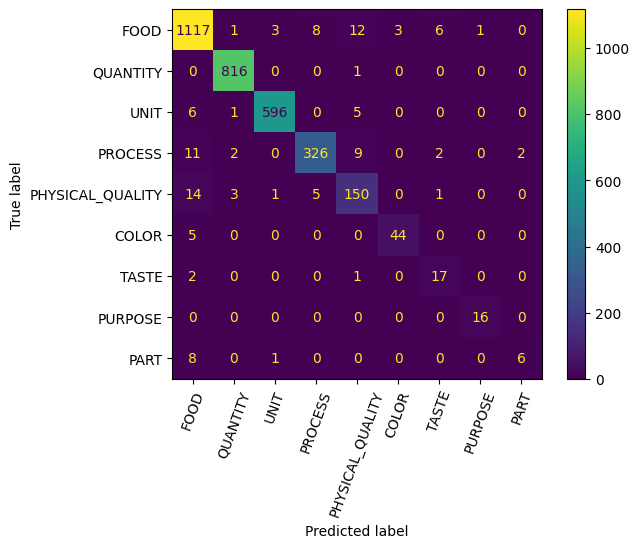

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# create and display the confusion matrix
cm = confusion_matrix(true_ents, pred_ents, labels=ENTITIES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ENTITIES)

disp.plot()
plt.xticks(rotation=70)
plt.show()

In [11]:
!pip install recipe-scrapers

     |████████████████████████████████| 193 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 531 kB 47.2 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 52.7 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 55.0 MB/s eta 0:00:01
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2401 sha256=e2defb6e0aa442e192cd98fa9d1eb9316964b45620c0021e5ec5d1fa20fcc58c
  Stored in directory: /home/himani/.cache/pip/wheels/d4/2a/06/11202ea86be0f51f34e9411d691e25b991d188d93ab4d3e551
Successfully built jstyleson


In [12]:
from recipe_scrapers import scrape_me

RECIPE_URL = "https://www.allrecipes.com/recipe/246868/pecan-sour-cream-coffee-cake/"
scraper = scrape_me(RECIPE_URL)
scraper.ingredients()

['1.5 cups pecans, finely chopped',
 '0.33333334326744 cup white sugar',
 '0.33333334326744 cup packed light brown sugar',
 '3 tablespoons melted butter',
 '1 teaspoon cinnamon',
 '0.125 teaspoon salt',
 '1.875 cups all-purpose flour',
 '1 teaspoon baking powder',
 '0.75 teaspoon baking soda',
 '0.5 teaspoon fine sea salt',
 '1 cup white sugar',
 '0.5 cup unsalted butter, softened',
 '2 large eggs',
 '1 cup sour cream or creme fraiche',
 '1.5 teaspoons vanilla extract']

In [13]:
from fractions import Fraction
import re


def fraction_to_mixed_number(fraction: Fraction) -> str:
  if fraction.numerator >= fraction.denominator:
    whole, remainder = divmod(fraction.numerator, fraction.denominator)
    if remainder == 0:
      return str(whole)
    else:
      return f"{whole} {Fraction(remainder, fraction.denominator)}"
  else:
    return str(fraction)


def convert_floats_to_fractions(text: str) -> str:
    return re.sub(
        r'\b-?\d+\.\d+\b',
        lambda match: fraction_to_mixed_number(
            Fraction(float(match.group())).limit_denominator()), text
        )


def process_text(text):
  """
  A wrapper function to pre-process text and run it through our pipeline.
  """
  return nlp(convert_floats_to_fractions(text))

In [14]:
# Let's have a look at our processing fucntion at work
[convert_floats_to_fractions(line) for line in scraper.ingredients()]

['1 1/2 cups pecans, finely chopped',
 '1/3 cup white sugar',
 '1/3 cup packed light brown sugar',
 '3 tablespoons melted butter',
 '1 teaspoon cinnamon',
 '1/8 teaspoon salt',
 '1 7/8 cups all-purpose flour',
 '1 teaspoon baking powder',
 '3/4 teaspoon baking soda',
 '1/2 teaspoon fine sea salt',
 '1 cup white sugar',
 '1/2 cup unsalted butter, softened',
 '2 large eggs',
 '1 cup sour cream or creme fraiche',
 '1 1/2 teaspoons vanilla extract']

In [15]:
# Load the model again for good measure
nlp = spacy.load('output_eff/model-best')

from spacy import displacy

In [16]:
# process the recipe, line-by-line
docs = [process_text(line) for line in scraper.ingredients()]

displacy.render(docs, style="ent", jupyter=True)

In [17]:
PREPPY_URL = 'https://preppykitchen.com/coffee-cake/'
scraper = scrape_me(PREPPY_URL, wild_mode=True)
scraper.ingredients()

['3/4 cup light brown sugar (150g)',
 '1/4 cup all purpose flour (30g)',
 '2 tsp ground cinnamon',
 '2/3 cup light brown sugar (133g, lightly packed)',
 '1 cup all-purpose flour (120g)',
 '2 tsp ground cinnamon',
 '¼ tsp salt',
 '1/2 cup unsalted butter (113g, diced)',
 '2 1/4 cup all-purpose flour ( 270g)',
 '1/4 cup cornstarch (30g)',
 '2 ½ tsp baking powder',
 '3/4 tsp salt',
 '¾ cup unsalted butter (170, at room temperature)',
 '1/2 cup brown sugar (100g)',
 '1 cup granulated sugar (200g)',
 '3 eggs (room temperature, large)',
 '2 tsp vanilla extract (10mL)',
 '1 cup sour cream (240mL, room temperature)']

In [18]:
# process the recipe, line-by-line
docs = [process_text(line) for line in scraper.ingredients()]

displacy.render(docs, style="ent", jupyter=True)